# Baseline Model and Training
## Setup and loading data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Uninstall existing versions:
#!pip uninstall numpy -y
#!pip uninstall pandas -y
#!pip uninstall tqdm -y
#!pip uninstall torch -y
#!pip uninstall scikit-plot -y
#!pip uninstall transformers -y

# Install packages:
#!pip install numpy==1.16.4
!pip install pandas
#!pip install tqdm==4.43.0
#!pip install torch==1.4.0
!pip install scikit-plot
!pip install transformers

     |████████████████████████████████| 1.4MB 5.7MB/s 
     |████████████████████████████████| 2.9MB 23.9MB/s 
     |████████████████████████████████| 890kB 43.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=84402a874df02508bbef076595ab4f864134cc2572374e7588000c7d15cb5c9a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pprint
pprint.pprint(sys.path)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

from collections import defaultdict
from collections import Counter

import datetime as dt
import re
import pickle
import torch
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import xgboost as xgb

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython']


In [ ]:
# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
import scikitplot as skplt

In [ ]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.DEBUG)
timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')
fh.setFormatter(formatter)
ch.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(ch)

In [ ]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [ ]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

In [ ]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [ ]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [ ]:
# Load data
file = open(train_dir + 'nontext_train_small.pickle', 'rb')
train_df = pickle.load(file)
file.close()
#train_df = pd.read_csv(train_dir + 'nontext_train_small.csv')
train_df

,target,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,,
1982-10-05,-1,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,0,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
2020-03-19,0,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
2020-03-23,0,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426


### Balancing the classes

In [ ]:
# Percentage before the balancing
n_hold = sum(1 for each in train_df['target'] if each == 0)
n_lower = sum(1 for each in train_df['target'] if each == -1)
n_raise = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)

print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


Here, take random sampling approach to balance the data. Though it loses some data, easy to process and less prone to the bias.<BER />

_Update: Decided not to do this as we do not have a lot of data. Consider different approach to tackle this imbalanced data issue. Thus, set keep_prob = 1 (keep everything). _

In [ ]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 0)
N_examples = len(train_df)

# Keep probability (specify decimal value between 0 and 1)
# keep_prob = (N_examples - n_hold)/2/n_hold
keep_prob = 1

balanced = pd.concat([train_df.loc[train_df['target'] != 0], train_df.loc[train_df['target'] == 0].sample(frac=keep_prob, random_state=1)])
balanced.sort_index(ascending=True, inplace=True)

n_hold = sum(1 for each in balanced['target'] if each == 0)
n_lower = sum(1 for each in balanced['target'] if each == -1)
n_raise = sum(1 for each in balanced['target'] if each == 1)
N_examples = len(balanced['target'])
print('Hold: ', round(n_hold/N_examples, 2))
print('Lower:', round(n_lower/N_examples, 2))
print('Raise:', round(n_raise/N_examples, 2))

Hold:  0.66
Lower: 0.18
Raise: 0.16


In [ ]:
def convert_class(x):
    if x == 1:
        return 3
    elif x == 0:
        return 2
    elif x == -1:
        return 1

In [ ]:
Y_balanced = balanced['target'].map(convert_class)
X_balanced = balanced.drop(columns=['target'])
Y_balanced
X_balanced

,prev_decision,GDP_diff_prev,PMI_value,Employ_diff_prev,Rsales_diff_year,Unemp_diff_prev,Inertia_diff,Hsales_diff_year,Balanced_diff
date,,,,,,,,,
1982-10-05,0,0.456197,38.8,-169.0,1.807631,-0.166667,-0.018226,-15.485275,0.003723
1982-11-16,-1,-0.382295,39.4,-228.0,1.807631,-0.200000,-0.018226,-9.537496,0.003723
1982-12-21,-1,-0.382295,39.2,-198.5,1.807631,-0.333333,-0.018226,-3.116275,0.003723
1983-01-14,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.018226,-0.774432,0.003723
1983-01-21,0,-0.382295,42.8,-68.0,1.807631,-0.233333,-0.043785,-0.774432,0.003723
...,...,...,...,...,...,...,...,...,...
2020-03-15,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.058085,13.910886,0.004279
2020-03-19,-1,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426
2020-03-23,0,0.527469,50.1,232.5,2.217385,0.000000,-0.057139,13.910886,0.001426


In [ ]:
# Because the prediction should be on the latest and should not look back, use shuffle=False
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_balanced.values, Y_balanced.values, test_size=0.2, shuffle=False)

In [ ]:
print("Training Data: Total {}, {}".format(len(Y_train), Counter(Y_train)))
print("Test Data: Total {}, {}".format(len(Y_test), Counter(Y_test)))

Training Data: Total 318, Counter({2: 203, 1: 63, 3: 52})
Test Data: Total 80, Counter({2: 58, 3: 13, 1: 9})


In [ ]:
Y_balanced.head()

date
1982-10-05    1
1982-11-16    1
1982-12-21    2
1983-01-14    2
1983-01-21    2
Name: target, dtype: int64

# Modeling and Training

## Briefly check how different classifiers perform

In [ ]:
# Use Stratified KFold Cross Validation
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

In [ ]:
# Roughly check base classifiers without hyperparameter setting

random_state = 2
classifiers = []
classifiers.append(("SVC", SVC(random_state=random_state)))
classifiers.append(("DecisionTree", DecisionTreeClassifier(random_state=random_state)))
classifiers.append(("AdaBoost", AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1)))
classifiers.append(("RandomForest", RandomForestClassifier(random_state=random_state, n_estimators=100)))
classifiers.append(("ExtraTrees", ExtraTreesClassifier(random_state=random_state)))
classifiers.append(("GradientBoosting", GradientBoostingClassifier(random_state=random_state)))
classifiers.append(("MultipleLayerPerceptron", MLPClassifier(random_state=random_state)))
classifiers.append(("KNeighboors", KNeighborsClassifier(n_neighbors=3)))
classifiers.append(("LogisticRegression", LogisticRegression(random_state = random_state)))
classifiers.append(("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis()))
classifiers.append(("GaussianNB", GaussianNB()))
classifiers.append(("Perceptron", Perceptron()))
classifiers.append(("LinearSVC", LinearSVC()))
classifiers.append(("SGD", SGDClassifier()))

cv_results = []
classifier_name = []
for classifier in classifiers :
    cv_results.append(cross_validate(classifier[1], X_train, y = Y_train, scoring = ["accuracy", "f1_macro"], cv = kfold, n_jobs=4))
    classifier_name.append(classifier[0])

cv_acc_means = []
cv_acc_std = []
cv_f1_means = []
cv_f1_std = []
for cv_result in cv_results:
    cv_acc_means.append(cv_result['test_accuracy'].mean())
    cv_acc_std.append(cv_result['test_accuracy'].std())
    cv_f1_means.append(cv_result['test_f1_macro'].mean())
    cv_f1_std.append(cv_result['test_f1_macro'].std())

cv_res = pd.DataFrame({"Algorithm": classifier_name,
                       "CVAccMeans":cv_acc_means,
                       "CVAccErrors": cv_acc_std,
                       "CVf1Means":cv_f1_means,
                       "CVf1Errors": cv_f1_std})

In [ ]:
cv_res.sort_values(by='CVAccMeans', ascending=False)

,Algorithm,CVAccMeans,CVAccErrors,CVf1Means,CVf1Errors
0,SVC,0.638440,0.006933,0.259768,0.001724
3,RandomForest,0.613872,0.084025,0.499901,0.133119
4,ExtraTrees,0.604555,0.089632,0.484787,0.129810
9,LinearDiscriminantAnalysis,0.600621,0.079205,0.441110,0.109036
5,GradientBoosting,0.572740,0.067923,0.473122,0.093812
6,MultipleLayerPerceptron,0.569220,0.074575,0.366500,0.137015
8,LogisticRegression,0.565977,0.064877,0.330084,0.056546
11,Perceptron,0.530918,0.134277,0.308106,0.083499
10,GaussianNB,0.526294,0.194258,0.491646,0.193769
1,DecisionTree,0.525949,0.121546,0.477166,0.128730


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

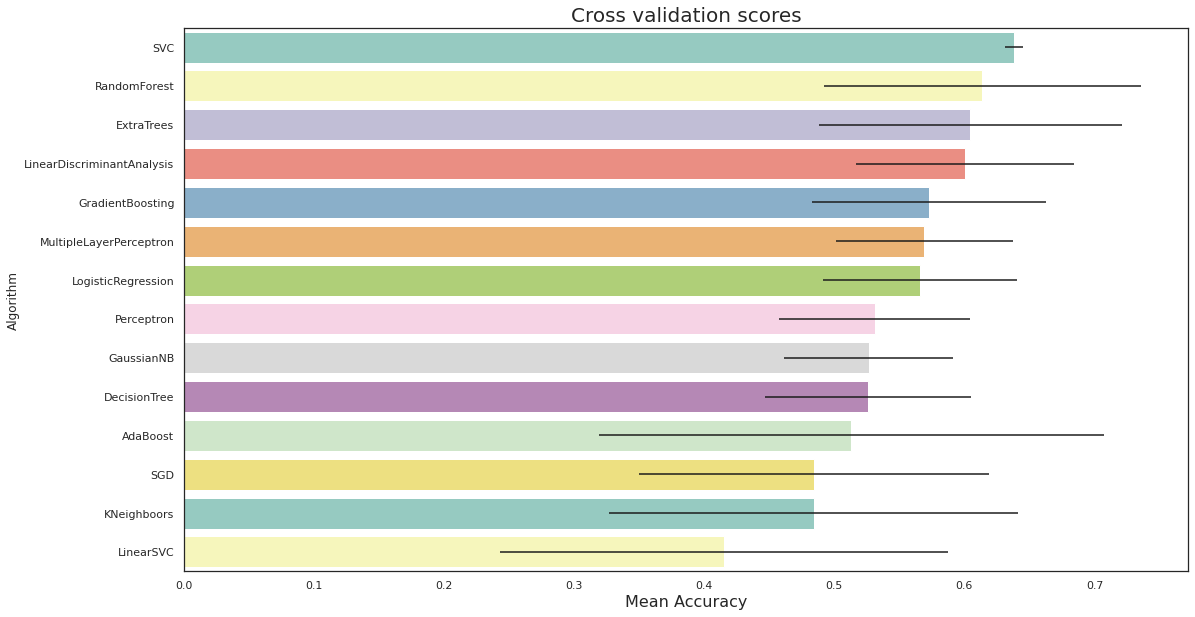

In [ ]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVAccMeans","Algorithm",data=cv_res.sort_values(by='CVAccMeans', ascending=False), palette="Set3", orient="h", **{'xerr':cv_acc_std})
ax.set_xlabel("Mean Accuracy", size=16)
ax.set_title("Cross validation scores", size=20)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Cross validation scores')

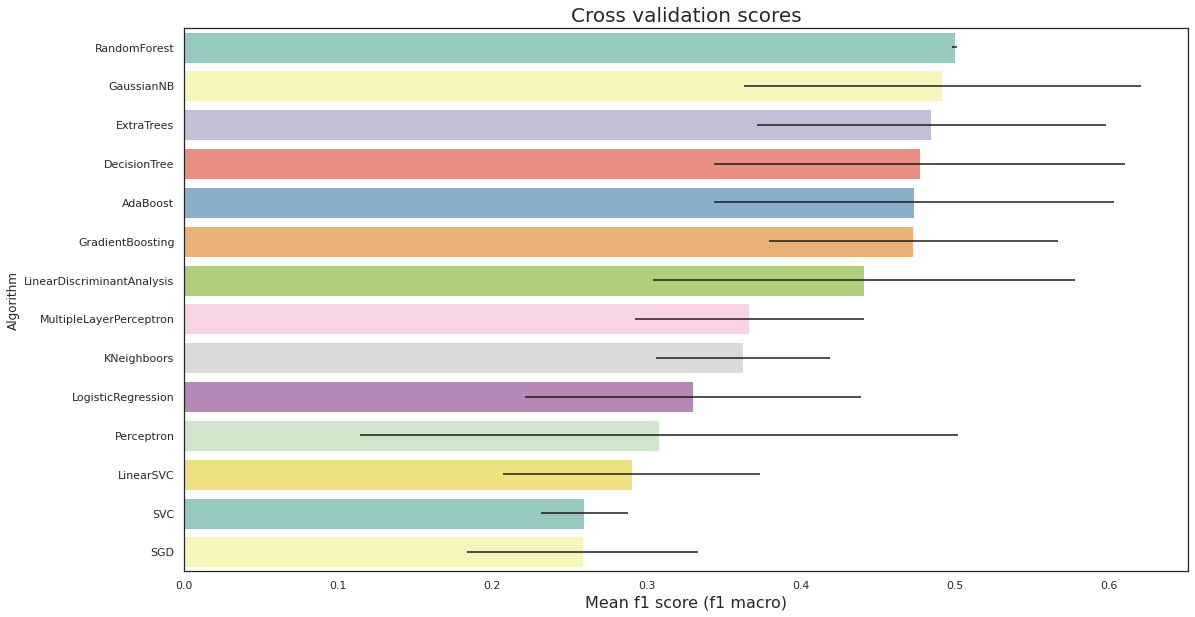

In [ ]:
plt.figure(figsize=(18,10))
ax = sns.barplot("CVf1Means","Algorithm",data=cv_res.sort_values(by='CVf1Means', ascending=False), palette="Set3", orient="h", **{'xerr':cv_f1_std})
ax.set_xlabel("Mean f1 score (f1 macro)", size=16)
ax.set_title("Cross validation scores", size=20)

## Hyperparameter Tuning
Grid search to find an optimal hyperparameter. First define functions to perform training and show results.

In [ ]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [ ]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model

### ADA Boost (on Decision Tree)

In [ ]:
# Define Classifier
DTC = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(DTC, random_state=rand_seed)

In [ ]:
# Perform Random Hyperparamter Grid Search
rand_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" : [10, 50, 100, 200, 500],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]}

rand_model = RandomizedSearchCV(estimator=ada_clf, param_distributions=rand_param_grid, 
                                 n_iter=300, cv=kfold, scoring=scoring[refit], verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.7s


0.48384574599440144
{'n_estimators': 500, 'learning_rate': 0.001, 'base_estimator__splitter': 'best', 'base_estimator__criterion': 'gini', 'algorithm': 'SAMME.R'}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:    3.7s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    0.8s finished
[2020-12-10 17:46:07,767][INFO] ## Training - acc: 1.00000000, f1: 1.00000000
[2020-12-10 17:46:07,770][INFO] ## Test - acc: 0.43750000, f1: 0.29121278


Best Score:  0.37360576621869923
Best Param:  {'algorithm': 'SAMME.R', 'base_estimator__criterion': 'gini', 'base_estimator__splitter': 'random', 'learning_rate': 0.01, 'n_estimators': 1}


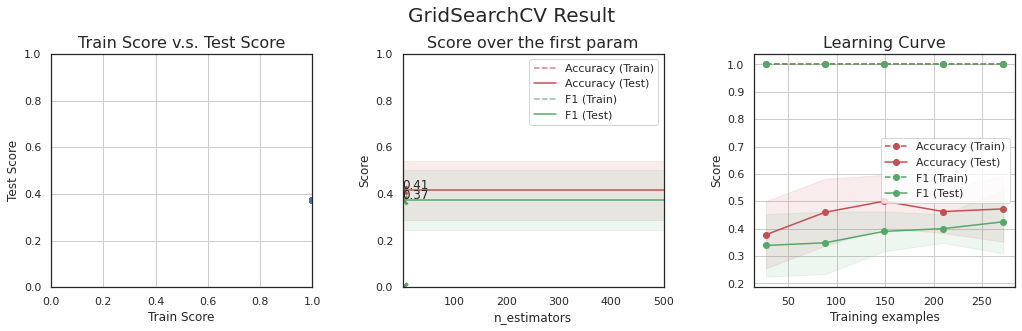

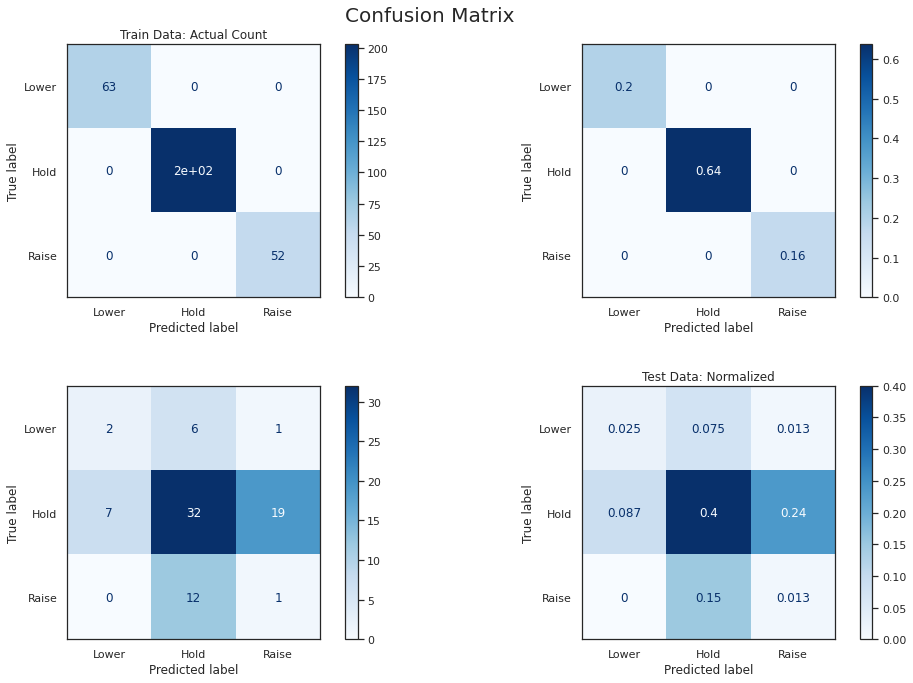

In [ ]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'base_estimator__criterion': ['gini'],
              'base_estimator__splitter': ['random'],
              'algorithm': ['SAMME.R'],
              'learning_rate': [0.01]}

ada_model = train_grid_search(ada_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ada_best = ada_model.best_estimator_

### Extra Tree

In [ ]:
#ExtraTrees 
ext_clf = ExtraTreesClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 10, 20],
              "min_samples_leaf": [1, 3, 5, 7, 10],
              "bootstrap": [False],
              "n_estimators" : [1, 2, 5, 10, 20, 100, 200, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=ext_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed,
                                n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1119 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1774 tasks      | elapsed:  1.9min


0.5579587826369649
{'n_estimators': 5, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  2.2min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    8.4s finished
[2020-12-10 17:48:30,952][INFO] ## Training - acc: 0.72641509, f1: 0.61778148
[2020-12-10 17:48:30,954][INFO] ## Test - acc: 0.62500000, f1: 0.25641026


Best Score:  0.4985771635705762
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 79}


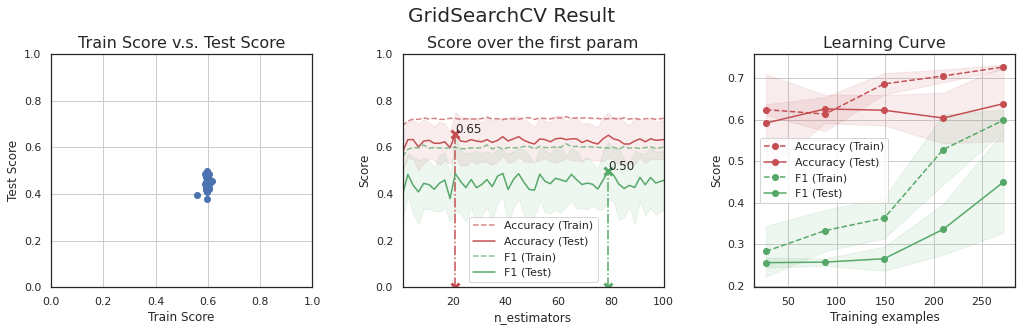

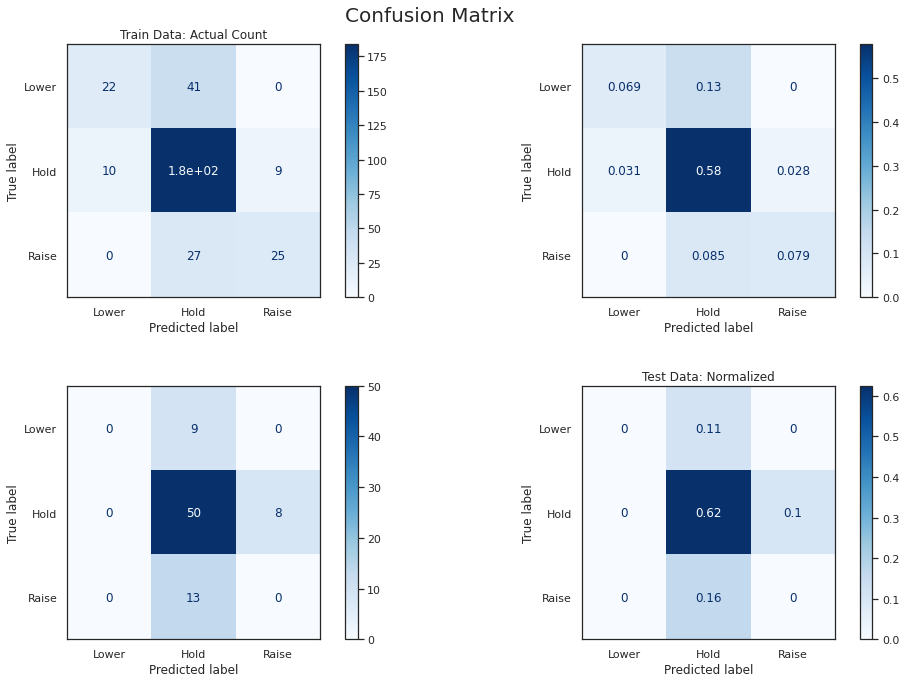

In [ ]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 100, 50, dtype=int),
              'min_samples_split': [5],
              'min_samples_leaf': [10],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

ext_model = train_grid_search(ext_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
ext_best = ext_model.best_estimator_

### Random Forest

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {"max_depth": [None],
              "max_features": [1, 2, 3, 5],
              "min_samples_split": [2, 3, 5, 7, 10],
              "min_samples_leaf": [1, 3, 5, 7, 10, 15],
              "bootstrap": [False],
              "n_estimators" :[1, 2, 5, 10, 100, 200, 300, 500, 1000],
              "criterion": ["gini"]}

rand_model = RandomizedSearchCV(estimator=rf_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                 random_state=rand_seed, n_jobs=-1)
rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 694 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1858 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2093 out of 2100 | elapsed:  3.7min remaining:    0.7s


0.5410496920418928
{'n_estimators': 100, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 3, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  3.7min finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  1.1min finished
[2020-12-10 17:53:23,596][INFO] ## Training - acc: 0.92767296, f1: 0.90903846
[2020-12-10 17:53:23,599][INFO] ## Test - acc: 0.62500000, f1: 0.49717357


Best Score:  0.5153975013708388
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 235}


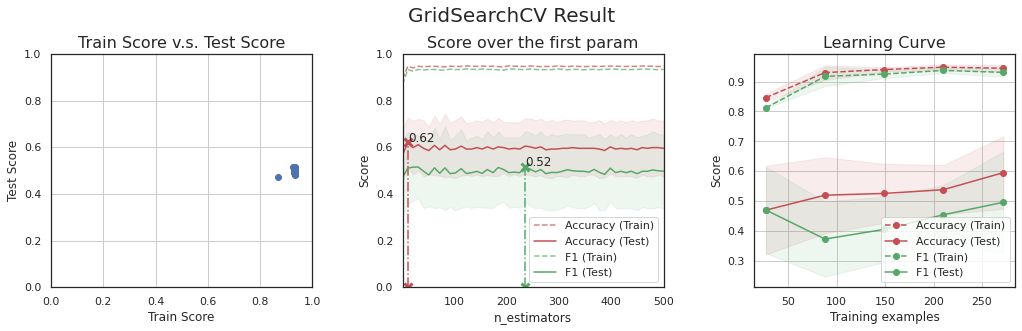

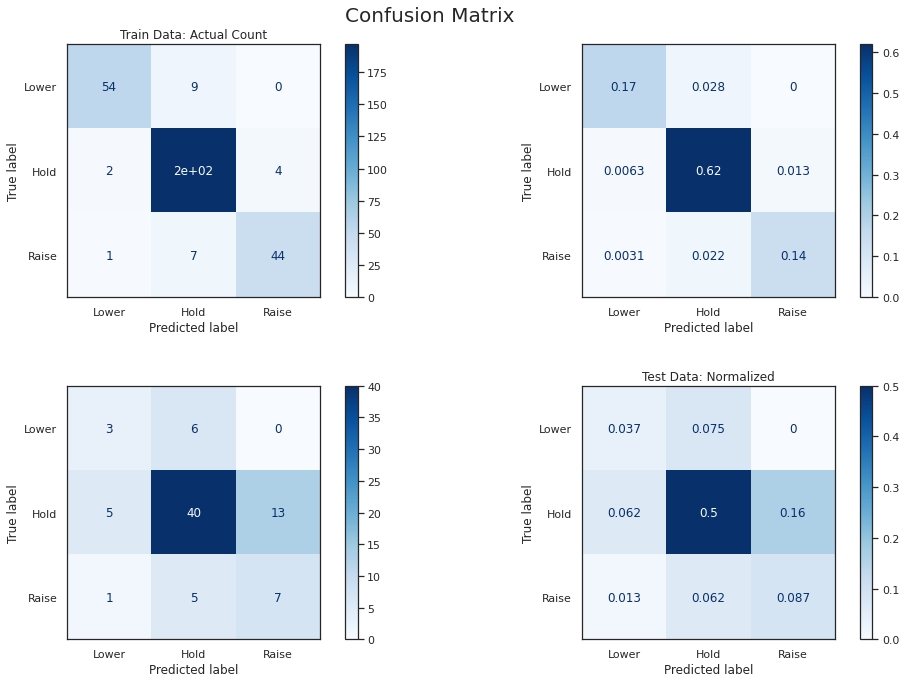

In [ ]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_split': [2],
              'min_samples_leaf': [3],
              'max_features': [8],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

### Gradient Boosting

In [ ]:
# Gradient boosting
gb_clf = GradientBoostingClassifier()

# Perform Random Hyperparamter Grid Search
rand_param_grid = {
    'loss' : ["deviance"],
    'n_estimators' : [1, 10, 100, 200, 300, 1000],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 5, 10, 15, 20, 30, 50, 100, 200, 300],
    'max_features': [0.8, 0.6, 0.4, 0.2, 0.1]
    }

rand_model = RandomizedSearchCV(estimator=gb_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed, 
                                n_jobs=-1)

rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 490 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 884 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1979 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 2093 out of 2100 | elapsed:  8.9min remaining:    1.8s
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  8.9min finished


0.525381640207931
{'n_estimators': 300, 'min_samples_leaf': 20, 'max_features': 0.6, 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.01}


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  1.1min finished
[2020-12-10 18:03:40,601][INFO] ## Training - acc: 0.79874214, f1: 0.73435315
[2020-12-10 18:03:40,603][INFO] ## Test - acc: 0.70000000, f1: 0.40317460


Best Score:  0.5168725605834373
Best Param:  {'learning_rate': 0.05, 'loss': 'deviance', 'max_depth': 2, 'max_features': 0.6, 'min_samples_leaf': 15, 'n_estimators': 82}


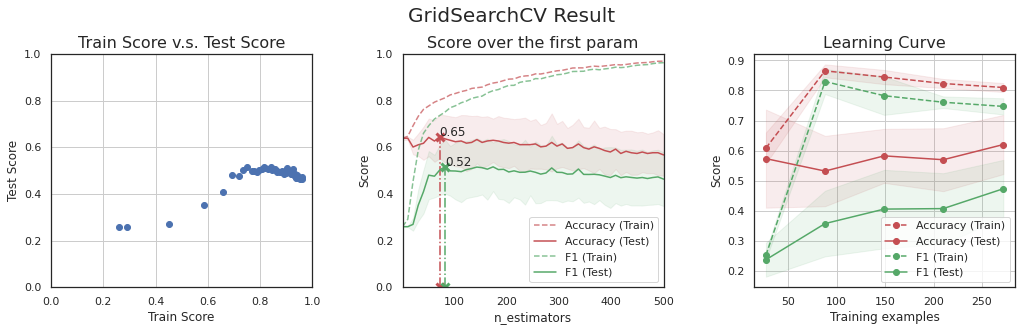

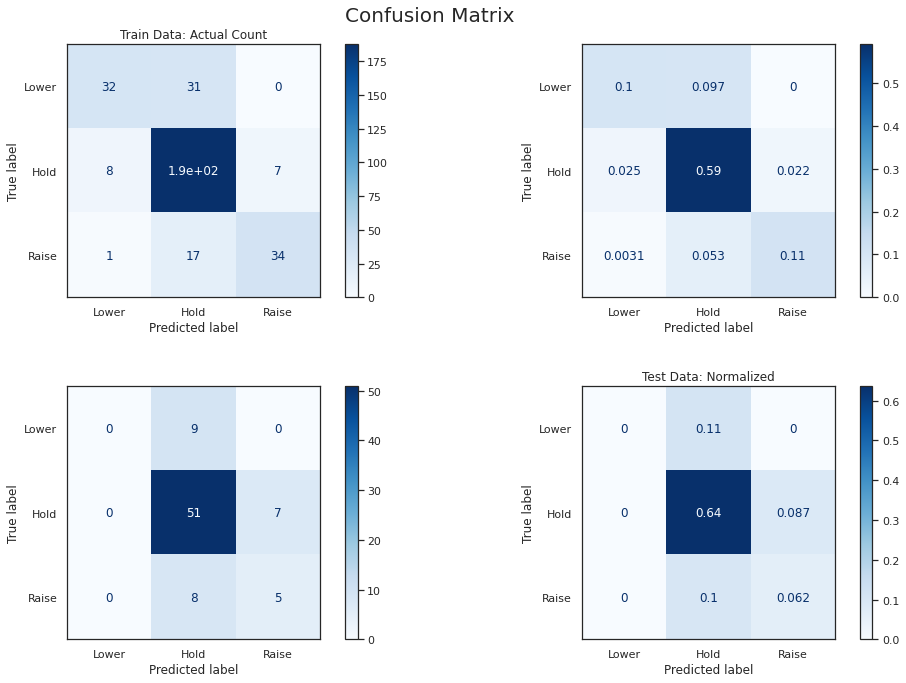

In [ ]:
# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 500, 50, dtype=int),
              'min_samples_leaf': [15],
              'max_features': [0.6],
              'max_depth': [2],
              'loss': ['deviance'],
              'learning_rate': [0.05]}

gb_model = train_grid_search(gb_clf, 
                             param_grid, 
                             scoring, 
                             refit, 
                             cv=kfold, 
                             verbose=1, 
                             plot=True)

gb_best = gb_model.best_estimator_

### SVM

In [ ]:
# Support Vector Machine
svm_clf = SVC(probability=True)

# Perform Random Hyperparameter Grid Search
rand_param_grid = {'kernel': ['rbf'], 
                  'gamma': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                  'C': [1, 2, 3, 5, 8, 10, 50, 100, 200, 300, 500, 1000]}

rand_model = RandomizedSearchCV(estimator=svm_clf, 
                                param_distributions=rand_param_grid, 
                                n_iter=300, 
                                cv=kfold, 
                                scoring=scoring[refit], 
                                verbose=1, 
                                random_state=rand_seed, 
                                n_jobs=-1)

rand_model.fit(X_train,Y_train)
print(rand_model.best_score_)
print(rand_model.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 84 is smaller than n_iter=300. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 84 candidates, totalling 588 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s


0.4645510437396955
{'kernel': 'rbf', 'gamma': 0.001, 'C': 100}


[Parallel(n_jobs=-1)]: Done 581 out of 588 | elapsed:    6.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 588 out of 588 | elapsed:    6.6s finished


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 7 folds for each of 50 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 343 out of 350 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    4.4s finished
[2020-12-10 18:03:57,119][INFO] ## Training - acc: 0.83018868, f1: 0.77562130
[2020-12-10 18:03:57,121][INFO] ## Test - acc: 0.62500000, f1: 0.37328491


Best Score:  0.42960685147685435
Best Param:  {'C': 10, 'gamma': 0.0021387755102040816, 'kernel': 'rbf'}


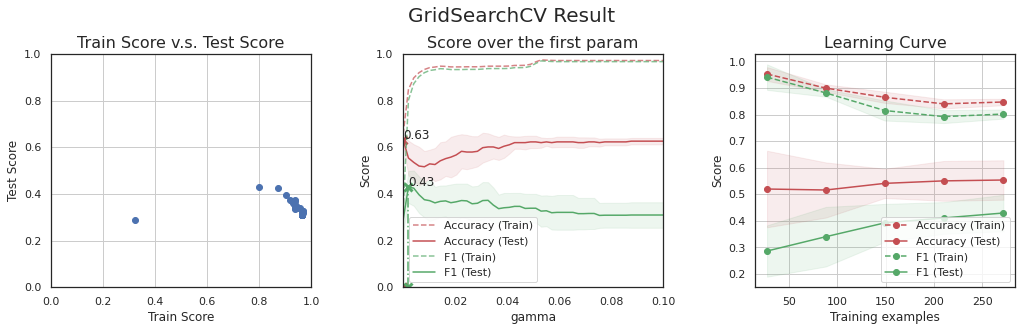

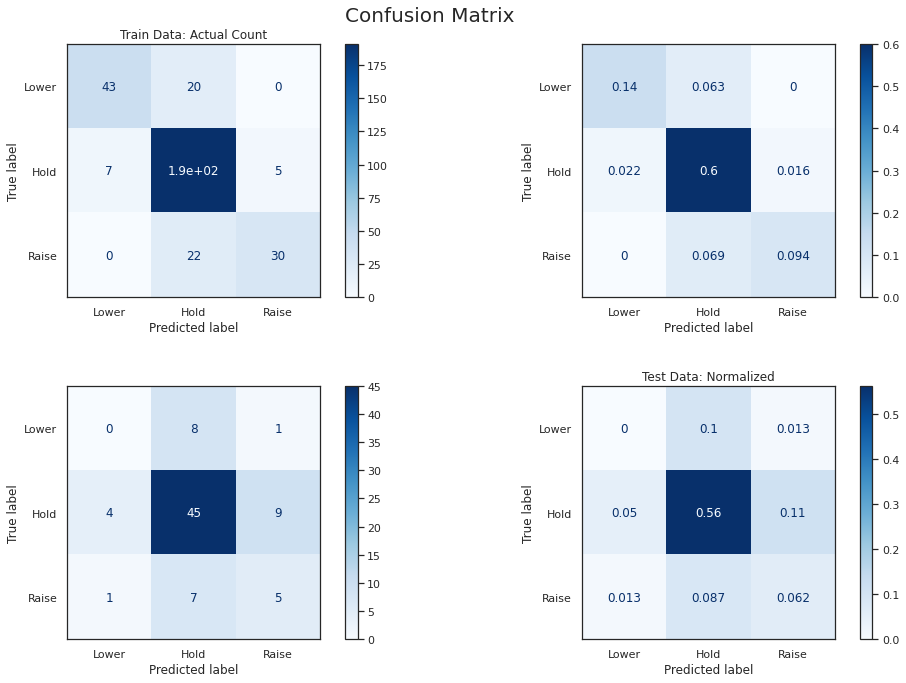

In [ ]:
# Perform Grid Search
param_grid = {'gamma': np.linspace(0.0001, 0.1, 50, dtype=float),
              'C': [10],
              'kernel': ['rbf']}

svm_model = train_grid_search(svm_clf, 
                              param_grid, 
                              scoring, 
                              refit, 
                              cv=kfold, 
                              verbose=1, 
                              plot=True)

svm_best = svm_model.best_estimator_

### Feature Importance
Check feature importance on four tree-based classifiers out of ten.

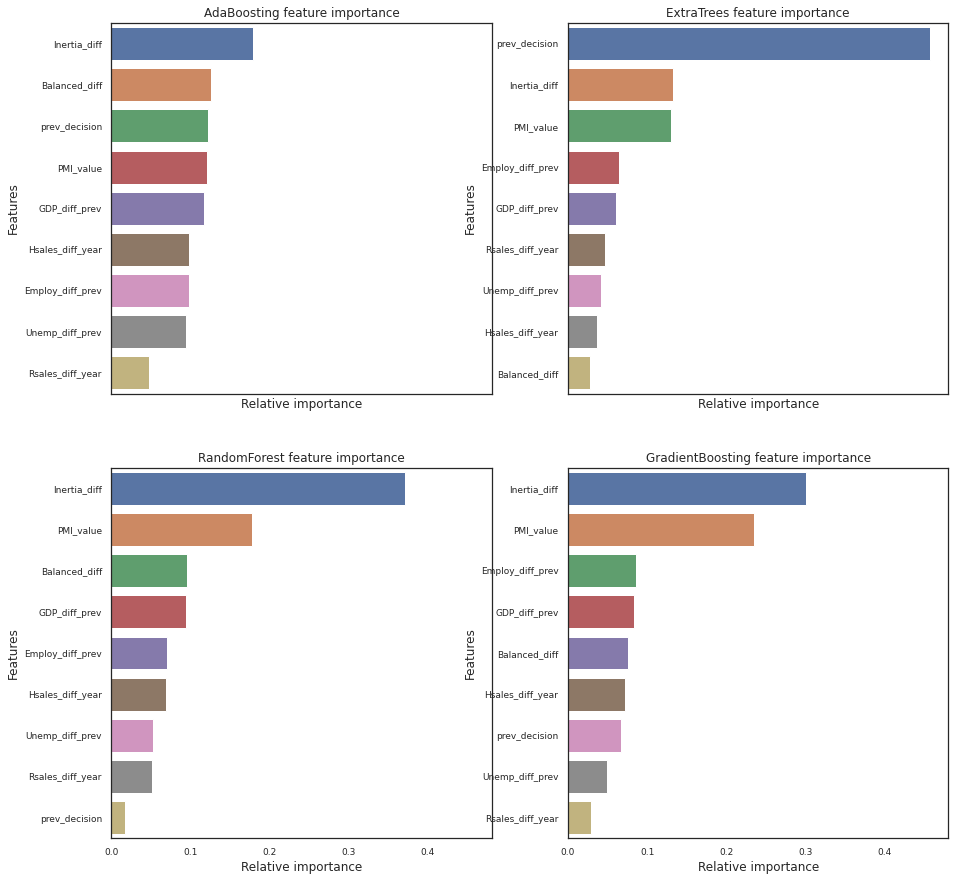

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best), 
                     ("ExtraTrees", ext_best), 
                     ("RandomForest", rf_best), 
                     ("GradientBoosting",gb_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_balanced.columns[indices][:40], x=classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

## Ensembling

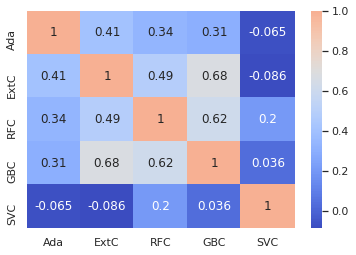

In [ ]:
test_ada = pd.Series(ada_best.predict(X_test), name="Ada")
test_ext = pd.Series(ext_best.predict(X_test), name="ExtC")
test_rf = pd.Series(rf_best.predict(X_test), name="RFC")
test_gb = pd.Series(gb_best.predict(X_test), name="GBC")
test_svm = pd.Series(svm_best.predict(X_test), name="SVC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=1)

g = sns.heatmap(ensemble_results.corr(),annot=True, cmap="coolwarm", center=0.7)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


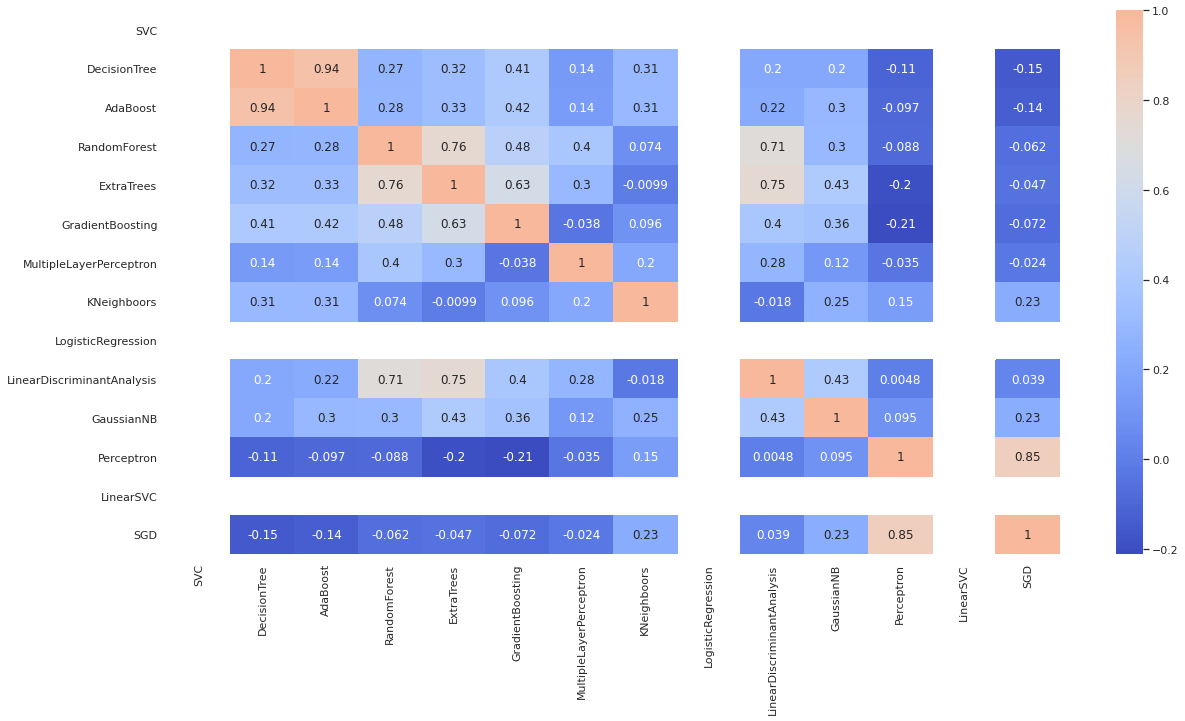

In [ ]:
# The same including all the other classifiers
test_resuts = []

for classifier in classifiers:
    estimator = classifier[1].fit(X_train, Y_train)
    test_resuts.append(pd.Series(estimator.predict(X_test), name=classifier[0]))

base_results = pd.concat(test_resuts, axis=1)

plt.figure(figsize=(20,10))
g = sns.heatmap(base_results.corr(),annot=True, cmap="coolwarm", center=0.7)

### Voting Classifier

In [ ]:
# Voting Classifier with "soft" to take all the probability into account
voting_best = VotingClassifier(estimators=[('adac', ada_best),
                                           ('extc', ext_best), 
                                           ('rfc', rf_best), 
                                           ('gbc', gb_best), 
                                           ('svmc', svm_best)], voting='soft', n_jobs=-1)

# Voting Classifier with "soft" to take all the probability into account
# voting_base = VotingClassifier(estimators=classifiers, voting='soft', n_jobs=4)

voting_best.fit(X_train, Y_train)

VotingClassifier(estimators=[('adac',
                              AdaBoostClassifier(algorithm='SAMME.R',
                                                 base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                       class_weight=None,
                                                                                       criterion='gini',
                                                                                       max_depth=None,
                                                                                       max_features=None,
                                                                                       max_leaf_nodes=None,
                                                                                       min_impurity_decrease=0.0,
                                                                                       min_impurity_split=None,
                                    

In [ ]:
# Predict
voting_pred_train = voting_best.predict(X_train)
voting_pred_test = voting_best.predict(X_test)

acc, f1 = metric(Y_train, voting_pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))

acc, f1 = metric(Y_test, voting_pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-12-10 18:04:02,845][INFO] ## Training - acc: 0.94654088, f1: 0.93431140
[2020-12-10 18:04:02,847][INFO] ## Test - acc: 0.62500000, f1: 0.31076389


### Stacking by XGBoost

In [ ]:
X_test_s = pd.DataFrame(X_test)
X_test_stacked = pd.concat([X_test_s, X_test_s, X_test_s, X_test_s, X_test_s], axis=0)
pred_test_stacked = pd.concat([test_ada, test_ext, test_rf, test_gb, test_svm],axis=0)
X_test_s = X_test_s
X_test_stacked = X_test_stacked
pred_test_stacked = pred_test_stacked
print(X_test_s)
print(X_test_stacked)
print(pred_test_stacked)

     0          1     2      3  ...          5          6        7           8
0    0   0.714973  56.6  168.5  ... -0.0333333          0 -17.4803           0
1    0   0.714973  52.9    148  ...  0.0333333          0 -14.5022           0
2    0   0.714973    53     93  ...          0          0 -11.2885           0
3   -1 -0.0277787  52.8  179.5  ...  0.0333333          0 -10.1406           0
4    0 -0.0277787  51.8  218.5  ...  0.0666667          0 -7.21511           0
..  ..        ...   ...    ...  ...        ...        ...      ...         ...
75  -1   0.527469  50.1  232.5  ...          0 -0.0580848  13.9109  0.00427873
76  -1   0.527469  50.1  232.5  ...          0 -0.0571394  13.9109  0.00142624
77   0   0.527469  50.1  232.5  ...          0 -0.0571394  13.9109  0.00142624
78   0   0.527469  50.1  232.5  ...          0  -0.114279  13.9109  0.00609178
79   0   0.527469  49.1   -561  ...       -0.3   -0.43152  12.4683   0.0402949

[80 rows x 9 columns]
     0          1     2      

In [ ]:
#gbm = xgb.XGBClassifier(
#    n_estimator = 2000, 
#    max_depth = 4, 
#    min_child_weight = 2, 
#    gamma = 0.9, 
#    subsample = 0.8, 
#    colsample_bytree = 0.8, 
#    objective = 'binary:logistic', 
#    nthread = -1, 
#    scale_pos_weight = 1).fit(X_test_stacked, pred_test_stacked)
#
# Predict
#gbm_pred_train = gbm.predict(pd.DataFrame(X_train.astype(str)))
#gbm_pred_test = gbm.predict(X_test_s)
#acc, f1 = metric(Y_train, gbm_pred_train)
#logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
#acc, f1 = metric(Y_test, gbm_pred_test)
#logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

# Result

In [ ]:
result_clf = [('AdaDTC', ada_best),
              ('ExtraTree', ext_best), 
              ('RandomForest', rf_best),
              ('GradientBoost', gb_best), 
              ('SVM', svm_best),
              ('Voting', voting_best)]

results = []

for clf in result_clf:
    pred_train = clf[1].predict(pd.DataFrame(X_train))
    pred_test = clf[1].predict(pd.DataFrame(X_test))
    train_acc, train_f1 = metric(Y_train, pred_train)
    test_acc, test_f1 = metric(Y_test, pred_test)
    results.append((clf[0], 
                    train_acc, 
                    train_f1, 
                    test_acc, 
                    test_f1))

result_df = pd.DataFrame(results, columns=[
                                           'Classifier', 
                                           'Train Accuracy', 
                                           'Train F1', 
                                           'Test Accuracy', 
                                           'Test F1'
                                           ]
                         )
result_df

,Classifier,Train Accuracy,Train F1,Test Accuracy,Test F1
0,AdaDTC,1.000000,1.000000,0.4375,0.291213
1,ExtraTree,0.726415,0.617781,0.6250,0.256410
2,RandomForest,0.927673,0.909038,0.6250,0.497174
3,GradientBoost,0.798742,0.734353,0.7000,0.403175
4,SVM,0.830189,0.775621,0.6250,0.373285
5,Voting,0.946541,0.934311,0.6250,0.310764


As Test F1 score is the highest, take Random Forest as the baseline model.

In [ ]:
baseline_model = rf_best
pred_test = baseline_model.predict(pd.DataFrame(X_test))
prediction_df = pd.concat([pd.Series(balanced.index.values), pd.Series(pred_test, name="Predict")],axis=1)

## Save the result

In [ ]:
  def save_data(df, file_name, dir_name, index_csv=True):
      if not os.path.exists(dir_name):
        os.mkdir(dir_name)
      # Save results to a pickle file
      file = open(dir_name + file_name + '.pickle', 'wb')
      pickle.dump(df, file)
      file.close()
      print(file_name + " saved in pickle format in: " + dir_name + file_name)
      # Save results to a csv file
      df.to_csv(dir_name + file_name + '.csv', index=index_csv)
      print(file_name + " saved in comma-separated format in: " + dir_name + file_name)

In [ ]:
# Save result
save_data(result_df, "result_scores", output_dir, index_csv=False)
save_data(prediction_df, "baseline_predictions", output_dir, index_csv=False)
save_data(X_balanced, "training_data", output_dir, index_csv=True)

result_scores saved in pickle format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/result_scores
result_scores saved in comma-separated format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/result_scores
baseline_predictions saved in pickle format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/baseline_predictions
baseline_predictions saved in comma-separated format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/baseline_predictions
training_data saved in pickle format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/training_data
training_data saved in comma-separated format at: /content/drive/My Drive/Colab Notebooks/proj2/src/data/result/training_data
